In [96]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import os
import warnings

import seaborn as sns
sns.set_style('whitegrid')

warnings.filterwarnings('ignore')
%matplotlib inline
from helpersNeuronalNet import*

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Analysis

In [91]:
from helpersNeuronalNet import*
DATA_TRAIN_PATH = "data/data_train.csv"
data = load_data(DATA_TRAIN_PATH)


DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

In [92]:
data_train, data_test,n_movies, n_users = splitClean(data)

## Analysis  on the ratings given by user

In [68]:
def human (num, units = 'K'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + "K"
    elif units == 'm':
        return str(num/10**6) + "M"
    elif units == 'b':
        return str(num/10**9) + "B"

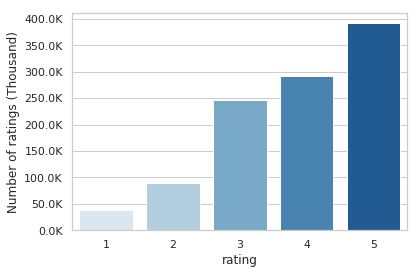

In [69]:
fig, ax = plt.subplots()
sns.countplot(data_train.rating, palette="Blues")
ax.set_yticklabels([human(item, 'K') for item in ax.get_yticks()])
ax.set_ylabel('Number of ratings (Thousand)')
plt.show()
fig.savefig('RatingsDistribution.png')

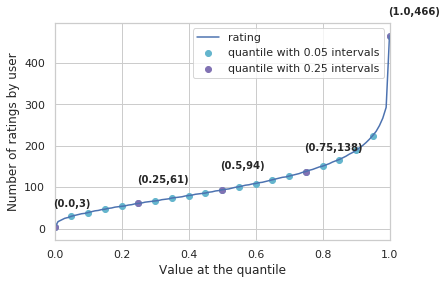

In [74]:
no_of_rated_movies_per_user = data_train.groupby(by='user_id')['rating'].count().sort_values(ascending = False)
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation = 'higher')


quantiles.plot()
plt.scatter (x = quantiles.index[::5], y = quantiles.values[::5], c='c', label = "quantile with 0.05 intervals")
plt.scatter (x = quantiles.index[::25], y = quantiles.values[::25], c='m', label = "quantile with 0.25 intervals")
plt.ylabel('Number of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc = 'best')

for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({},{})".format(x,y),xy=(x,y),xytext=(x-0.005,y+50), fontweight ='bold' )

plt.savefig('quantiles.png')
plt.show()


In [75]:
quantiles [::5]
# 10% of users rated more then 189 movies

0.00      3
0.05     30
0.10     39
0.15     47
0.20     54
0.25     61
0.30     67
0.35     74
0.40     80
0.45     86
0.50     94
0.55    101
0.60    109
0.65    118
0.70    127
0.75    138
0.80    151
0.85    167
0.90    189
0.95    225
1.00    466
Name: rating, dtype: int64

In [79]:
print('\n No of ratings at last 10 percentile: {}\n'.format(sum(no_of_rated_movies_per_user>=189)))


 No of ratings at last 10 percentile: 1011



## Analysis of ratings of a movie given by a user

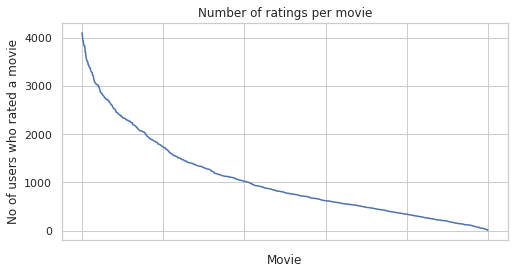

In [83]:
no_of_ratings_per_movie = data_train.groupby(by='movie_id')['rating'].count().sort_values(ascending = False)

fig = plt.figure(figsize = plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('Number of ratings per movie')
plt.xlabel('Movie')
plt.ylabel('No of users who rated a movie')
ax.set_xticklabels([])

plt.savefig('Number of ratings per movie')
plt.show()

In [102]:
from optimizer import*
prev_neurons = 100
prev_embedding = 50
prev_dropout = 0.05

max_nb_layers = 20
max_nb_neurons = 200
max_nb_embedding = 150

max_iter = 100
n_iter = 0

break_ind = 0

max_accurracy = 0

while (n_iter<max_iter) & (break_ind == 0):
    next_layer, accurracy_layer = layers(max_nb_layers, prev_neurons, prev_dropout,  prev_embedding, data)
    if (accurracy_layer >= max_accurracy):
        max_accurracy = accurracy_layer
        prev_layer = next_layer
    next_neurons, accurracy_neurons = neurons(next_layer, max_nb_neurons, prev_dropout, prev_embedding, data)
    if (accurracy_neurons >= max_accurracy):
        max_accurracy = accurracy_neurons
        prev_neurons = next_neurons
    next_embedding, accurracy_embeddinglayers = embeddinglayer(prev_layer, prev_neurons, prev_dropout, max_nb_embedding, data)
    if (accurracy_embeddinglayers>= max_accurracy):
        max_accurracy = accurracy_embeddinglayers
        prev_embedding = next_embedding
    next_dropout, accurracy_dropout = optimize_dropout(prev_layer, prev_neurons, prev_embedding, data)
    if (accurracy_dropout<= max_accurracy):
        max_accurracy = accurracy_embeddinglayers
        prev_dropout = next_dropout
    elif (n_iter>max_iter/2):
        break_ind = 1
    
    n_iter+=1
    print ('New iteration')

print ('Simulation finished')

model = generate(prev_layer, prev_neurons, prev_dropout, n_users, n_movies, prev_embedding)
model.save('model_optimizeLayerNeuronsDropoutEmbedding.h5')

Train on 1059257 samples, validate on 117695 samples
Epoch 1/10000
 365568/1059257 [=========>....................] - ETA: 14s - loss: 1.3581 - accuracy: 0.4159

KeyboardInterrupt: 

## Optimize Layers, Neurons, Dropouts & Models

In [30]:
X_samples = samples[['user', 'movie']].values
X_samples_array = [X_samples[:,0], X_samples[:,1]]

In [31]:
sample_pred = model.predict(X_samples_array)

In [32]:
rating_samples = (np.argmax(sample_pred,1)+1).tolist()

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

samples['rating'] = rating_samples

In [33]:
from helpers import create_csv
PATH_SUBMISSION = "data/OptimizerLayerNeuronsPrediction.csv"
create_csv(PATH_SUBMISSION, samples)

In [43]:
X=np.random.randint(1000, size=(32, 10))

X.shape

(32, 10)